In [1]:
# load package
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation  import train_test_split
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import cross_validation

# set path
import os
default_path = "/Users/francislin/Desktop/Machine_Learning_Workshop/Titanic/"
os.chdir(default_path)

# skip interaction warning
import warnings; 
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Data Prepararion
# read data
train=pd.read_csv('train.csv',encoding='big5')
test=pd.read_csv('test.csv',encoding='big5')
submit=pd.read_csv('gender_submission.csv',encoding='big5')

In [3]:
# append in ONE data
data=train.append(test, ignore_index=True)

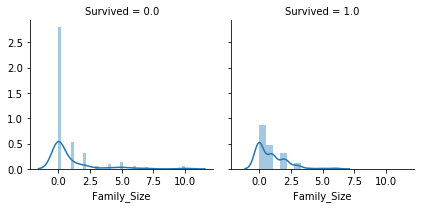

In [4]:
data['Family_Size']=data['Parch']+data['SibSp']
g=sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'Family_Size',kde=True)#kde是否要折線圖的參數

In [5]:
#設法整理出「尊稱」這個因子
data['Title1']=data['Name'].str.split('.',expand=True)[0]
#expand=True是讓資料在dataframe展開欄位
#1是選第二項的title
data['Title1'].head(10)
# 切出尊稱
data['Title1']=data['Title1'].str.split(', ',expand=True)[1].str.strip()#[1]代表切出第2個'dlm'前面到第一個的字串
data['Title1'].head(10)
# 秀出dintinct後的title1
data['Title1'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [6]:
#合併成比較常出現的姓氏在Title2
data['Title2']=''
for idx, row in data.iterrows():  # 請務必記得加上idx，不然跑回圈的item會變成(idx, row)
    Sex = row['Sex']
    Title1=row['Title1']
    if Title1=='Master':
        Title2='Master'
    elif Title1=='Mrs':
        Title2='Mrs'
    elif Title1=='Miss':
        Title2='Miss'
    elif Sex=='male':
        Title2='Mr'
    else:
        Title2='Miss'
    data.loc[idx,'Title2']=Title2 #???
data['Title2'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

In [7]:
# 票的前幾碼代號可能有意義，流水編沒有所以拿掉
data['Ticket_info'] = data['Ticket'].apply(lambda x : x.replace(".","").replace("/","").strip().split(' ')[0] if not x.isdigit() else 'X')
data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [8]:
tt = data.groupby(by='Ticket_info', as_index=False).agg({'PassengerId': pd.Series.nunique})

In [9]:
tt['PassengerId'].describe()

count     37.000000
mean      35.378378
std      156.804434
min        1.000000
25%        1.000000
50%        4.000000
75%        9.000000
max      957.000000
Name: PassengerId, dtype: float64

In [10]:
#把count distinct的ticket_info低於第一四分位數的都改成None
tt['Ticket_info_rev']=tt['Ticket_info']
tt.Ticket_info_rev[tt.PassengerId<9]='None'
tt.head(4)

,Ticket_info,PassengerId,Ticket_info_rev
0,A,1,None
1,A4,10,A4
2,A5,28,A5
3,AQ3,1,None


In [11]:
#leftjoin Ticket_info_rev到大表
tt=tt.drop(['PassengerId'], axis=1)
data=pd.merge(left=data, right=tt,how='left', on=['Ticket_info', 'Ticket_info'])
data.head(4)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info,Ticket_info_rev
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1,Mr,Mr,A5,A5
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,1,Mrs,Mrs,PC,PC
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0,Miss,Miss,STONO2,None
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,1,Mrs,Mrs,X,X


In [12]:
# 抓船艙第一碼英文
# 送出kaggle成績沒有比較好，一堆空的也是合理
data['Cabin_info']=data['Cabin'].str[:1]
data['Cabin_info']=data['Cabin_info'].fillna('N')#空的補N
data['Cabin_info'].unique()

array(['N', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [13]:
'''
data['Cabin_info2']=data['Cabin_info']
data.Cabin_info2[data.Cabin_info in ('N','C')]='mm'
data.head()'''

"\ndata['Cabin_info2']=data['Cabin_info']\ndata.Cabin_info2[data.Cabin_info in ('N','C')]='mm'\ndata.head()"

In [14]:
#整併人數太少的cabin
#把'F','G','T'變成'Merged'
data['Cabin_info'].replace(['F','G','T'],'Merged',inplace=True)#inplace如果是false就是改爽的不會更動到值

In [15]:
#
print('Embarked原遺漏的人數：',data['Embarked'].isnull().sum())
#最多在S港上傳，填補遺漏值
data['Embarked']=data['Embarked'].fillna('S')

Embarked原遺漏的人數： 2


In [16]:
#
print('Fare原遺漏的人數：',data['Fare'].isnull().sum())
#用平均填補遺漏值
data['Fare']=data['Fare'].fillna(data['Fare'].mean())

Fare原遺漏的人數： 1


In [17]:
#
#print('Age遺漏的人數：',data['Age'].isnull().sum())
#用中位數填補遺漏值
#data['Age']=data['Age'].fillna(data['Age'].median())

In [18]:
#用(找是否有別名
data['NickName_ind']= data['Name'].str.contains('\(',na=False)*1

In [19]:
#留下準備get_dummies的欄位
for_dummy_data=data.drop(['Name','Cabin','Ticket','Ticket_info','Title1'], axis=1)
for_dummy_data.head(3)

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Family_Size,Title2,Ticket_info_rev,Cabin_info,NickName_ind
0,22.0,S,7.2500,0,1,3,male,1,0.0,1,Mr,A5,N,0
1,38.0,C,71.2833,0,2,1,female,1,1.0,1,Mrs,PC,C,1
2,26.0,S,7.9250,0,3,3,female,0,1.0,0,Miss,None,N,0


In [20]:
data_dummies = pd.get_dummies(for_dummy_data)
#columns可以指定哪些欄位要get_dummies
data_dummies.head(3)
#data= pd.merge(left=data, right=data_dummies, how='left', left_on='PassengerId', right_on='PassengerId',)
#data.head(4)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,Family_Size,NickName_ind,Embarked_C,...,Ticket_info_rev_STONO,Ticket_info_rev_WC,Ticket_info_rev_X,Cabin_info_A,Cabin_info_B,Cabin_info_C,Cabin_info_D,Cabin_info_E,Cabin_info_Merged,Cabin_info_N
0,22.0,7.2500,0,1,3,1,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,2,1,1,1.0,1,1,1,...,0,0,0,0,0,1,0,0,0,0
2,26.0,7.9250,0,3,3,0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
data_dummies.columns

Index(['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'SibSp', 'Survived',
       'Family_Size', 'NickName_ind', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Sex_female', 'Sex_male', 'Title2_Master', 'Title2_Miss', 'Title2_Mr',
       'Title2_Mrs', 'Ticket_info_rev_A4', 'Ticket_info_rev_A5',
       'Ticket_info_rev_CA', 'Ticket_info_rev_FCC', 'Ticket_info_rev_None',
       'Ticket_info_rev_PC', 'Ticket_info_rev_SCPARIS',
       'Ticket_info_rev_SOTONOQ', 'Ticket_info_rev_STONO',
       'Ticket_info_rev_WC', 'Ticket_info_rev_X', 'Cabin_info_A',
       'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_E',
       'Cabin_info_Merged', 'Cabin_info_N'],
      dtype='object')

In [22]:
#感覺是把文字類別轉成某種數字
#get_dummies了所以不必這一cell
'''
data['Sex'] = data['Sex'].astype('category').cat.codes
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data['Pclass'] = data['Pclass'].astype('category').cat.codes
data['Title2'] = data['Title2'].astype('category').cat.codes
data['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes
data['Cabin_info'] = data['Cabin_info'].astype('category').cat.codes
data.head(4)
'''

"\ndata['Sex'] = data['Sex'].astype('category').cat.codes\ndata['Embarked'] = data['Embarked'].astype('category').cat.codes\ndata['Pclass'] = data['Pclass'].astype('category').cat.codes\ndata['Title2'] = data['Title2'].astype('category').cat.codes\ndata['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes\ndata['Cabin_info'] = data['Cabin_info'].astype('category').cat.codes\ndata.head(4)\n"

In [23]:
# 運用'Survived'欄位來判斷訓練集還是測試集
dataTrain = data_dummies[pd.notnull(data_dummies['Survived'])].sort_values(by=["PassengerId"])
dataTest = data_dummies[~pd.notnull(data_dummies['Survived'])].sort_values(by=["PassengerId"])
dataTrain.columns
dataTrain = dataTrain[['Age', 'Fare', 'Parch', 'Pclass','Survived', 'SibSp',
       'Family_Size', 'NickName_ind', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female',
       'Sex_male', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',# 'Title2_Master'
       #'Ticket_info_rev_A4', 'Ticket_info_rev_A5', 'Ticket_info_rev_CA',
       #'Ticket_info_rev_FCC', 'Ticket_info_rev_None', 'Ticket_info_rev_PC',
       #'Ticket_info_rev_SCPARIS', 'Ticket_info_rev_SOTONOQ', 'Ticket_info_rev_WC','Ticket_info_rev_STONO'
       'Ticket_info_rev_X',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']]
dataTest = dataTest[['Age', 'Fare', 'Parch', 'Pclass', 'SibSp',
       'Family_Size', 'NickName_ind', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female',
       'Sex_male', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',# 'Title2_Master'
       #'Ticket_info_rev_A4', 'Ticket_info_rev_A5', 'Ticket_info_rev_CA',
       #'Ticket_info_rev_FCC', 'Ticket_info_rev_None', 'Ticket_info_rev_PC',
       #'Ticket_info_rev_SCPARIS', 'Ticket_info_rev_SOTONOQ', 'Ticket_info_rev_WC','Ticket_info_rev_STONO',
       'Ticket_info_rev_X',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']]

In [24]:
# Function for Measure Performance
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

In [25]:
# use LabelEncoder to convert categorical features to int type before construct Dataset
from sklearn.preprocessing import LabelEncoder
def label_encoder(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """
    # Label encode categoricals
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
    return input_df, categorical_feats.tolist(), encoder_dict
dataTrain, categorical_feats, encoder_dict = label_encoder(dataTrain)
X = dataTrain.drop('Survived', axis=1)
y = dataTrain.Survived

# Prepare dataset 
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=seed)

In [26]:
# Grid Search
print('Start training...')
estimator = lgb.LGBMClassifier(objective = 'binary', learning_rate = 0.05, n_estimators = 100, random_state=0)

param_grid = {
    'num_leaves': [14,15,16],
    #[30,40,50] then 30 [20,25,30] then 20 [17,20,23] then 17 [15,17,19] then 15 [14,15,16] then 14
    'feature_fraction': [0.3,0.4,0.5],#[0.4,0.6,0.8] then 0.4
    'bagging_fraction': [0.2,0.3,0.4],#[0.6,0.7,0.8], then 0.6 [0.4,0.5,0.6] then 0.4 [0.3,0.4,0.5] then 0.3
    'max_depth':[5,6],#[4,6,8] then 6
    'max_bin':[15], #[10,15,20] then 15 [13,15,17] then 15 [14,15,16] then 15
    'lambda_l1':[0.6,0.7,0.8],#[0.1,0.2,0.3] then 0.3 [0.3,0.4,0.5] then 0.5 [0.5,0.6,0.7] then 0.7
    'lambda_l2':[0.06,0.07,0.08], #[0.08,0.09,0.1] then 0.08 [0.06,0.07,0.08] then 0.06
    'min_split_gain':[0.07],#[0.05,0.06,0.07]then 0.07
    'min_child_weight':[4] #[3,5,7] then 5 [4,5,6] then 5 [4,5,6] then 4 [3,4,5] then 4
}

LGBM_grid = GridSearchCV(estimator, param_grid)
LGBM_grid.fit(X_train, y_train)
print('Best parameters found by grid search are:', LGBM_grid.best_params_)

# Final Model
evals_result = {} 
print('Start predicting...')
LGBM_grid_final = lgb.LGBMClassifier(objective = 'binary',
                                      learning_rate = 0.05, 
                                     n_estimators = 100, 
                                     random_state=0,
                              num_leaves = LGBM_grid.best_params_['num_leaves'],
                                feature_fraction = LGBM_grid.best_params_['feature_fraction'], 
                              bagging_fraction = LGBM_grid.best_params_['bagging_fraction'],
                             max_depth = LGBM_grid.best_params_['max_depth'],
                              max_bin = LGBM_grid.best_params_['max_bin'],
                              lambda_l1 = LGBM_grid.best_params_['lambda_l1'],
                              lambda_l2 = LGBM_grid.best_params_['lambda_l2'],
                            min_split_gain = LGBM_grid.best_params_['min_split_gain'],
                            min_child_weight = LGBM_grid.best_params_['min_child_weight'])
LGBM_grid_final_fit = LGBM_grid_final.fit(X_train, y_train)
print('Predicting is over')

Start training...
Best parameters found by grid search are: {'bagging_fraction': 0.3, 'feature_fraction': 0.5, 'lambda_l1': 0.6, 'lambda_l2': 0.06, 'max_bin': 15, 'max_depth': 6, 'min_child_weight': 4, 'min_split_gain': 0.07, 'num_leaves': 14}
Start predicting...
Predicting is over


Accuracy:0.780
Classification report
             precision    recall  f1-score   support

        0.0       0.78      0.87      0.82       156
        1.0       0.78      0.65      0.71       112

avg / total       0.78      0.78      0.78       268

Confusion matrix
[[136  20]
 [ 39  73]]
ROC AUC Score
0.8313587454212454
Feature importances: [244, 191, 8, 57, 28, 73, 28, 26, 0, 27, 16, 18, 5, 48, 1, 16, 12, 47]
Plot feature importances...


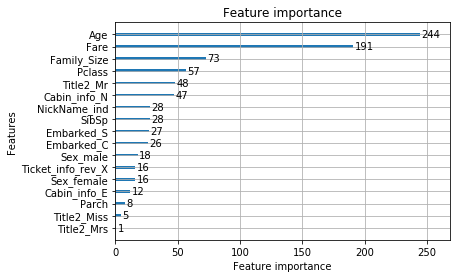

In [27]:
LGBM_grid_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_grid_final, show_classification_report=True, show_confusion_matrix=True)

# feature importances
print('Feature importances:', list(LGBM_grid_final.feature_importances_))

# visualization
print('Plot feature importances...')
ax = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=20)
plt.show()

In [28]:
#predict Test data
#submit the data to kaggle
LGBM_grid_final_fit_res =LGBM_grid_final_fit.predict(dataTest)
submit['Survived'] = LGBM_grid_final_fit_res
#submit['Survived'] = GBDT_res
submit['Survived'] = submit['Survived'].astype(int)

In [29]:
submit.to_csv('submit_to_kaggle.csv', index= False)
%pwd

'/Users/francislin/Desktop/Machine_Learning_Workshop/Titanic'

In [30]:
print("一樣的x去做")
#print('\n')
print("CART:"+"Your submission scored 0.74641")
print("RF:"+"Your submission scored 0.76076")
print("GBDT:"+"Your submission scored 0.77511")
print("RF(18個X):"+"Your submission scored 0.79425")
print("lightGBM(用綽號、年紀遺漏不處理):"+"Your submission scored 0.79904")

一樣的x去做
CART:Your submission scored 0.74641
RF:Your submission scored 0.76076
GBDT:Your submission scored 0.77511
RF(18個X):Your submission scored 0.79425
lightGBM(用綽號、年紀遺漏不處理):Your submission scored 0.79904


#### Important Features Using Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
imp = sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), X_train.columns), reverse=True)
rf_imp = pd.DataFrame(imp, columns=['importances', 'features'])
rf_imp